In [2]:
import json
import requests
import os

In [3]:
coco_json_path = '../extra/coco_json/person_keypoints_val2017.json'

with open(coco_json_path, 'r') as file:
    coco_data = json.load(file)

In [4]:
coco_data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

## Code for downloading the images

In [23]:
# Directory to save the download images
output_dir = 'coco_images/'

# Create the output directory 
os.makedirs(output_dir, exist_ok=True)

# Get the list of images
images = coco_data['images']

# Download the first five images
for i in range(5):
    image_info = images[i]
    image_url = image_info['coco_url']
    image_id = image_info['id']
    file_name = f"{output_dir}/{str(image_id).zfill(12)}.jpg"

    # Send a request to download the image
    response = requests.get(image_url)

    # Save the image to the specified file path
    with open(file_name, 'wb') as file:
        file.write(response.content)
        print(f"Image saved: {file_name}")


Image saved: coco_images//000000397133.jpg
Image saved: coco_images//000000037777.jpg
Image saved: coco_images//000000252219.jpg
Image saved: coco_images//000000087038.jpg
Image saved: coco_images//000000174482.jpg


In [6]:
coco_data['annotations'][0]['num_keypoints']

10

In [7]:
coco_data['images'][1]

{'license': 1,
 'file_name': '000000037777.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000037777.jpg',
 'height': 230,
 'width': 352,
 'date_captured': '2013-11-14 20:55:31',
 'flickr_url': 'http://farm9.staticflickr.com/8429/7839199426_f6d48aa585_z.jpg',
 'id': 37777}

# This will download all images only having num_keypoints > 10

In [13]:
# Directory to save the download images
output_dir = 'coco_images'

# Create the output directory 
os.makedirs(output_dir, exist_ok=True)

# Get the list of annotations
annotations = coco_data['annotations']

# Create a set to store image IDs with num_keypoints > 10
valid_image_ids = set()

# Iterate over the annotations to find valid image IDs
for annotation in annotations:
    num_keypoints = annotation['num_keypoints']
    if num_keypoints > 10:
        image_id = annotation['image_id']
        valid_image_ids.add(image_id)

# Get the list of images
images = coco_data['images']

# Download images with valid image IDs
# Download the first five images If you want to download all, just remove the counter
counter = 0
for image_info in images:
    if counter >= 5:
        break

    image_id = image_info['id']
    if image_id in valid_image_ids:
        image_url = image_info['coco_url']
        file_name = f"{output_dir}/{str(image_id).zfill(12)}.jpg"


        # Send a request to download the image
        response = requests.get(image_url)

        # Save the image to the specified file path
        with open(file_name, 'wb') as file:
            file.write(response.content)
            print(f"Image saved: {file_name}")

        counter += 1


Image saved: coco_images/000000397133.jpg
Image saved: coco_images/000000252219.jpg
Image saved: coco_images/000000087038.jpg
Image saved: coco_images/000000296649.jpg
Image saved: coco_images/000000386912.jpg


# Selecting those images that have persons in them

In [3]:
from pycocotools.coco import COCO

# Path to the JSON annotation files
train_annotation_file = '../../extra/coco_json/person_keypoints_train2017.json'
val_annotation_file = '../../extra/coco_json/person_keypoints_val2017.json'

# Initialize COCO instances for train and val annotations
coco_train = COCO(train_annotation_file)
coco_val = COCO(val_annotation_file)

# Filter images in the train set
train_image_ids = coco_train.getImgIds(catIds=coco_train.getCatIds('person'))
filtered_train_image_ids = []
for image_id in train_image_ids:
    ann_ids = coco_train.getAnnIds(imgIds=image_id, iscrowd=None)
    annotations = coco_train.loadAnns(ann_ids)
    if any(annotation['category_id'] == 1 for annotation in annotations):  # Person category ID is 1
        filtered_train_image_ids.append(image_id)

# Filter images in the validation set
val_image_ids = coco_val.getImgIds(catIds=coco_val.getCatIds('person'))
filtered_val_image_ids = []
for image_id in val_image_ids:
    ann_ids = coco_val.getAnnIds(imgIds=image_id, iscrowd=None)
    annotations = coco_val.loadAnns(ann_ids)
    if any(annotation['category_id'] == 1 for annotation in annotations):  # Person category ID is 1
        filtered_val_image_ids.append(image_id)

# Print the number of filtered images in train and val sets
print(f"Filtered Train Images: {len(filtered_train_image_ids)}")
print(f"Filtered Val Images: {len(filtered_val_image_ids)}")


loading annotations into memory...
Done (t=9.26s)
creating index...
index created!
loading annotations into memory...
Done (t=1.17s)
creating index...
index created!
Filtered Train Images: 64115
Filtered Val Images: 2693


## Convert COCO to YOLO format for labels

In [1]:
from ultralytics.yolo.data.converter import convert_coco
convert_coco(labels_dir='coco_json_val/', use_keypoints=True)

Annotations /home/rigvedrs/AI/Red Hen/Github/Handling COCO/coco_json_val/person_


## Display the annotations from the COCO labels

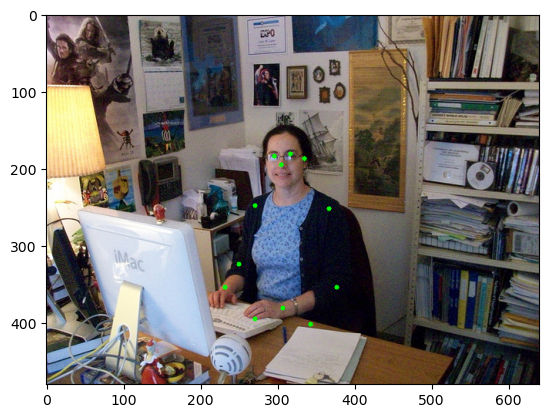

In [41]:
import cv2
import matplotlib.pyplot as plt
import json

# Load the COCO JSON file
with open(coco_json_path) as f:
    data = json.load(f)

# Select an image by its ID
image_id = 386912
image_data = next(item for item in data['images'] if item['id'] == image_id)
fname = image_data['file_name']
# image_path = f'styled_images/{fname}'
image_path = f'coco_images/{fname}'

# Load the image
image = cv2.imread(image_path)

# Get the annotations for the selected image
annotations = [item for item in data['annotations'] if item['image_id'] == image_id]

# Draw the keypoints on the image
for annotation in annotations:
    keypoints = annotation['keypoints']
    for i in range(0, len(keypoints), 3):
        x = keypoints[i]
        y = keypoints[i+1]
        v = keypoints[i+2]  # visibility flag
        if v > 0:
            cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


## Display Keypoints using the YOLO labels

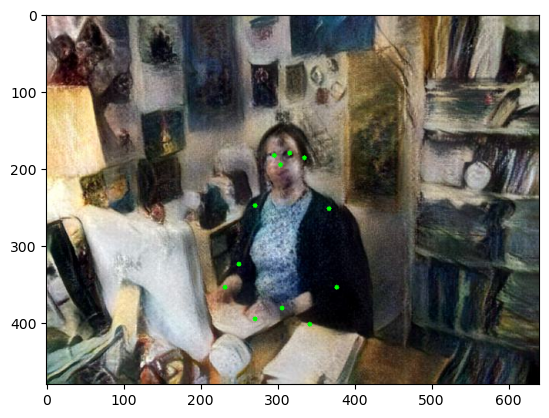

In [49]:
import cv2
import matplotlib.pyplot as plt

# Select an image by its ID
image_id = 386912
fname = f"{str(image_id).zfill(12)}.jpg"

image_path = f'styled_images/{fname}'
# image_path = f'coco_images/{fname}'

# Load the image
image = cv2.imread(image_path)

# Load the keypoints from the corresponding text file
keypoints_file = f'yolo_labels/labels/person_keypoints_val2017/{str(image_id).zfill(12)}.txt'
with open(keypoints_file, 'r') as f:
    keypoints_data = f.read().split()

# The first five items are the class index and the bounding box coordinates
class_index = int(keypoints_data[0])
bbox_x, bbox_y, bbox_width, bbox_height = map(float, keypoints_data[1:5])

# The remaining items are the keypoints
keypoints_data = keypoints_data[5:]
keypoints = [(float(keypoints_data[i]), float(keypoints_data[i+1]), int(keypoints_data[i+2])) for i in range(0, len(keypoints_data), 3)]

# Draw the keypoints on the image
for x, y, v in keypoints:
    # Scale the keypoints to the size of the image
    x = int(x * image.shape[1])
    y = int(y * image.shape[0])

    # Draw the keypoint on the image if it's visible
    if v > 0:
        cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
